In [1]:
import os 
import pandas as pd
import numpy as np


In [4]:
CONSENSUS_RATIO = 0.5
MIN_SIZE = 200
USE_POST_PROCESSING = False

In [5]:
ensemble_dir = ('runs/families')

runs = os.listdir(ensemble_dir)

df = []
for exp_name in runs:
    submission_path = os.path.join(ensemble_dir, exp_name, 'results.json')
    assert os.path.exists(submission_path)
    if exp_name == '3-convnext':
        weight = 84.6
    elif exp_name == '4-mask2former':
        weight = 84.8
    elif exp_name == '5-segformer':
        weight = 84.6
    elif exp_name == '2-regnet':
        weight = 84.8
    else:
        print('skip', exp_name)
        continue
        
        # raise ValueError(f'Unknown exp_name: {exp_name}')
    df.append({'name': exp_name, 
               'weights_path': os.path.join(ensemble_dir, exp_name, 'best.ckpt'), 
               'submission': submission_path,
                'weight': weight
                })

skip 1-resnet


In [6]:
df = pd.DataFrame(df)
df

name                                       weights_path  \
0     3-convnext  /home/tuantran/ucc-ai-quest-2023/runs/families...   
1    5-segformer  /home/tuantran/ucc-ai-quest-2023/runs/families...   
2       2-regnet  /home/tuantran/ucc-ai-quest-2023/runs/families...   
3  4-mask2former  /home/tuantran/ucc-ai-quest-2023/runs/families...   

                                          submission  weight  
0  /home/tuantran/ucc-ai-quest-2023/runs/families...    84.6  
1  /home/tuantran/ucc-ai-quest-2023/runs/families...    84.6  
2  /home/tuantran/ucc-ai-quest-2023/runs/families...    84.8  
3  /home/tuantran/ucc-ai-quest-2023/runs/families...    84.8

In [7]:
# read submission files
import json
import cv2
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt

from pkg.utils import rle_to_mask, mask_to_rle, mask_to_rgb, show_in_grid

In [8]:
"""
json format
results[filename] = {
    "counts": rle,
    "height": pred.shape[0],
    "width": pred.shape[1],
}
"""

'\njson format\nresults[filename] = {\n    "counts": rle,\n    "height": pred.shape[0],\n    "width": pred.shape[1],\n}\n'

In [9]:
def plot_mask_from_rle(rle, h, w):
    mask = rle_to_mask(rle, (h, w))
    mask = mask_to_rgb(mask, {1: [55, 125, 34]})
    plt.imshow(mask)
    plt.show()

In [10]:
# TEST_DATA_DIR = '../data/public/img/test'
TEST_DATA_DIR = '../data/private/img/test'


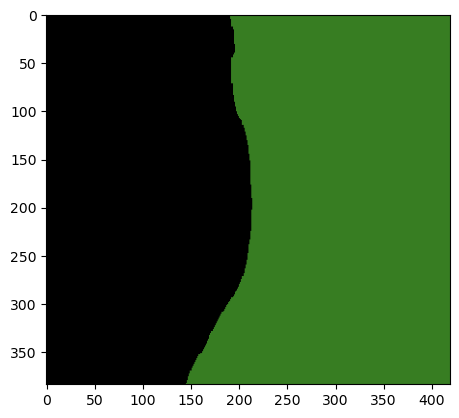

In [11]:
with open(df['submission'][0], 'r') as f:
    submission = json.load(f)
    
filename = list(submission.keys())[4]
rle = submission[filename]['counts']

h = submission[filename]['height']
w = submission[filename]['width']
plot_mask_from_rle(rle, w, h)

In [12]:
masks = []
filenames = []
for i in range(5):
    filename = list(submission.keys())[i]
    rle = submission[filename]['counts']

    h = submission[filename]['height']
    w = submission[filename]['width']   
    mask = rle_to_mask(rle, (w, h))
    masks.append(mask)
    filenames.append(filename)
    

In [13]:
images = [Image.open(os.path.join(TEST_DATA_DIR, filename)) for filename in filenames]

In [14]:
for image, mask in zip(images, masks):
    print(image.size, mask.shape)

(464, 384) (384, 464)
(517, 384) (384, 517)
(509, 384) (384, 509)
(467, 384) (384, 467)
(419, 384) (384, 419)


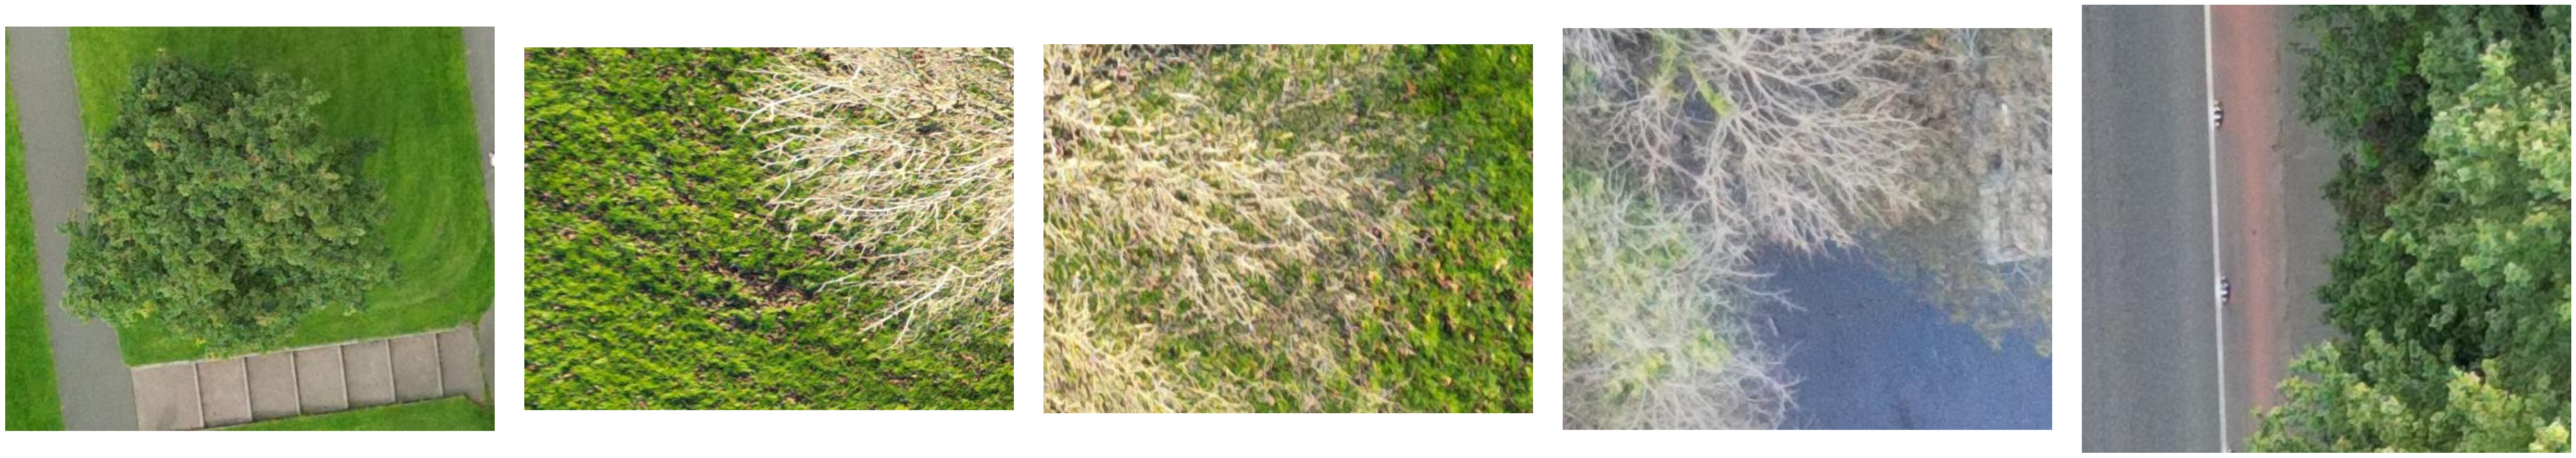

In [15]:
show_in_grid(images, num_rows=1, num_cols=5, show_plot=True)
plt.show()

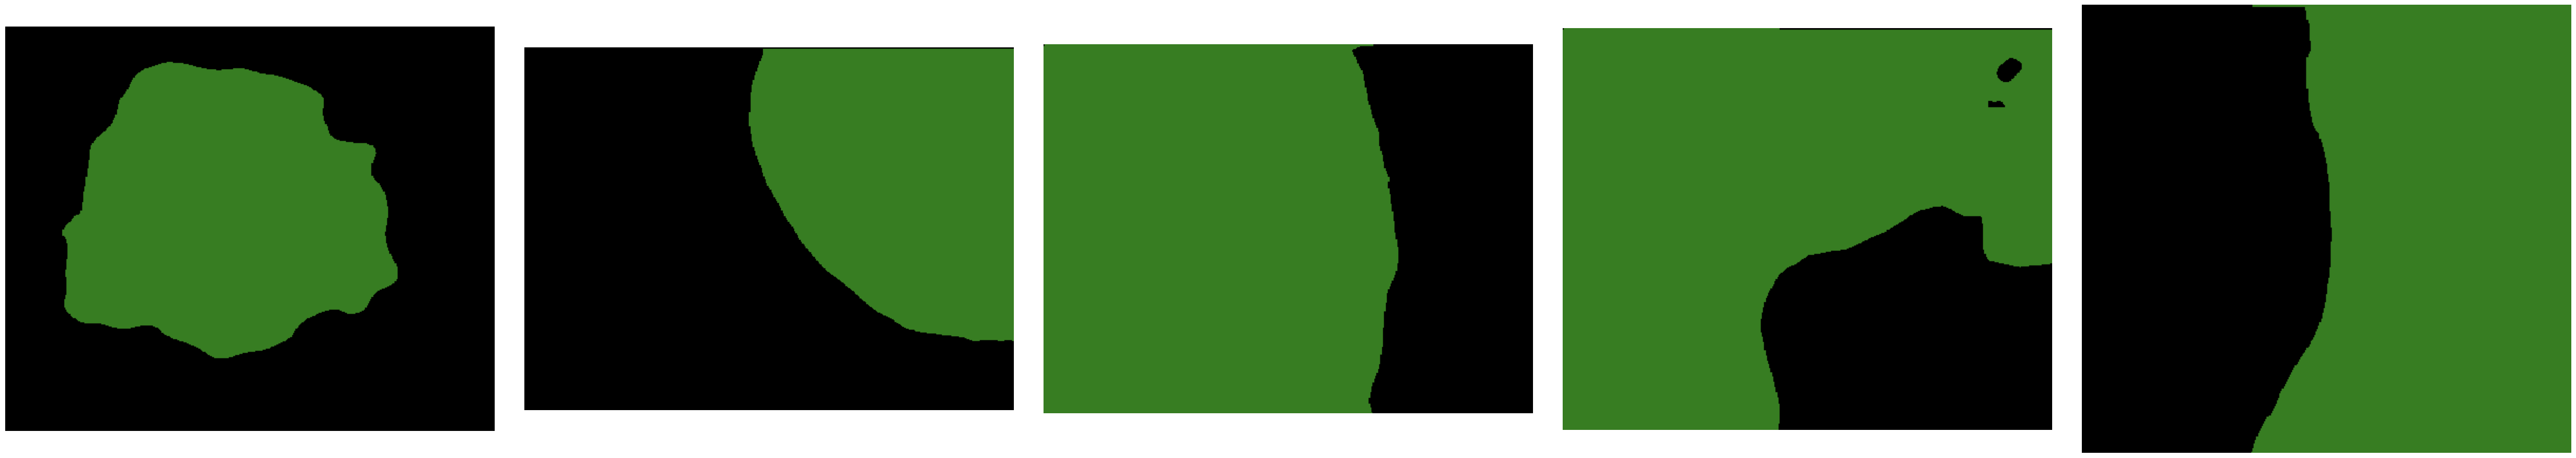

In [16]:
mask_rgb = [mask_to_rgb(mask, {1: [55, 125, 34]}) for mask in masks]
show_in_grid(mask_rgb, num_rows=1, num_cols=5, show_plot=True)
plt.show()

In [17]:
def weighted_average_ensemble_masks(masks, weights, threshold):
    """
    Args:
        masks: list of numpy array
        weights: list of float
    
    Returns:
        numpy array
    """
    if weights is None:
        weights = [1.0] * len(masks)
    else:
        assert len(weights) == len(masks)
    
    # normalize weights
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    
    # weighted average
    mask = np.zeros_like(masks[0], dtype=np.float32)
    for i in range(len(masks)):
        mask += weights[i] * masks[i]
    
    # threshold
    mask = np.where(mask > threshold, 1, 0).astype(np.uint8)
    return mask


    

In [18]:
## post processing

def post_process_mask(mask, min_size):
    """
    Args:
        mask: numpy array
        min_size: int
    
    Returns:
        numpy array
    """
    num_components, component_list = cv2.connectedComponents(mask.astype(np.uint8))
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    for c in range(1, num_components):
        component = (component_list == c).astype(np.uint8)
        if component.sum() > min_size:
            new_mask += component
    return new_mask

In [19]:
submissions = []
for row in df.itertuples():
    with open(row.submission, 'r') as f:
        submission = json.load(f)
    submissions.append(submission)



In [20]:
import tqdm.notebook as tqdm


In [21]:
file_list = list(submissions[0].keys())
for file in tqdm.tqdm(file_list):
    masks = []
    weights = []
    for i, submission in enumerate(submissions):
        rle = submission[file]['counts']
        h = submission[file]['height']
        w = submission[file]['width']
        mask = rle_to_mask(rle, (w, h))
        weight = df.iloc[i]['weight']
        masks.append(mask)
        weights.append(weight)
    image = Image.open(os.path.join(TEST_DATA_DIR, file), 'r')
    ensemble_mask = weighted_average_ensemble_masks(masks, weights, CONSENSUS_RATIO)
    if USE_POST_PROCESSING:
        ensemble_mask = post_process_mask(ensemble_mask, MIN_SIZE)
    assert ensemble_mask.shape[0] == image.size[1]
    assert ensemble_mask.shape[1] == image.size[0]

    rle = mask_to_rle(ensemble_mask)
    break

  0%|          | 0/783 [00:00<?, ?it/s]

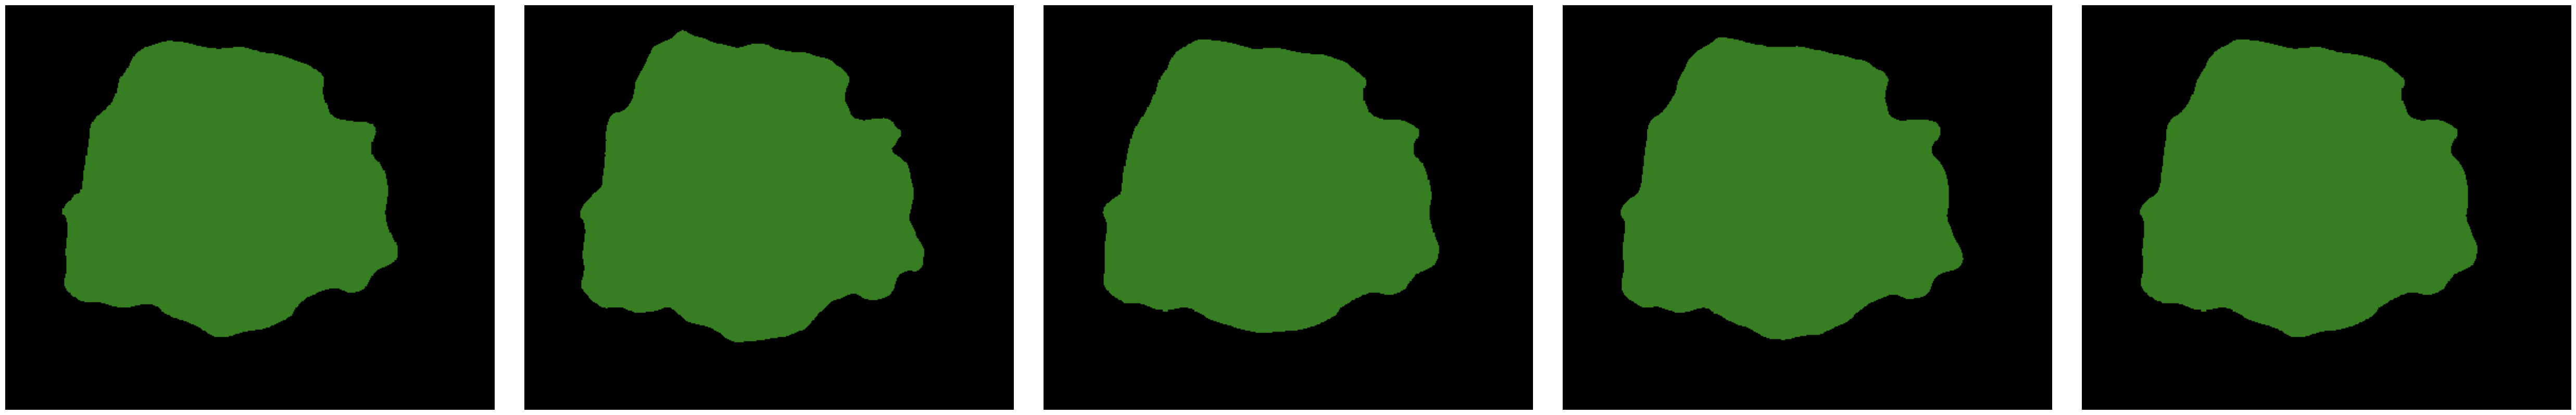

In [22]:
masks.append(ensemble_mask)
show_in_grid([mask_to_rgb(mask, {1: [55, 125, 34]}) for mask in masks], num_rows=1, num_cols=len(masks), show_plot=True)

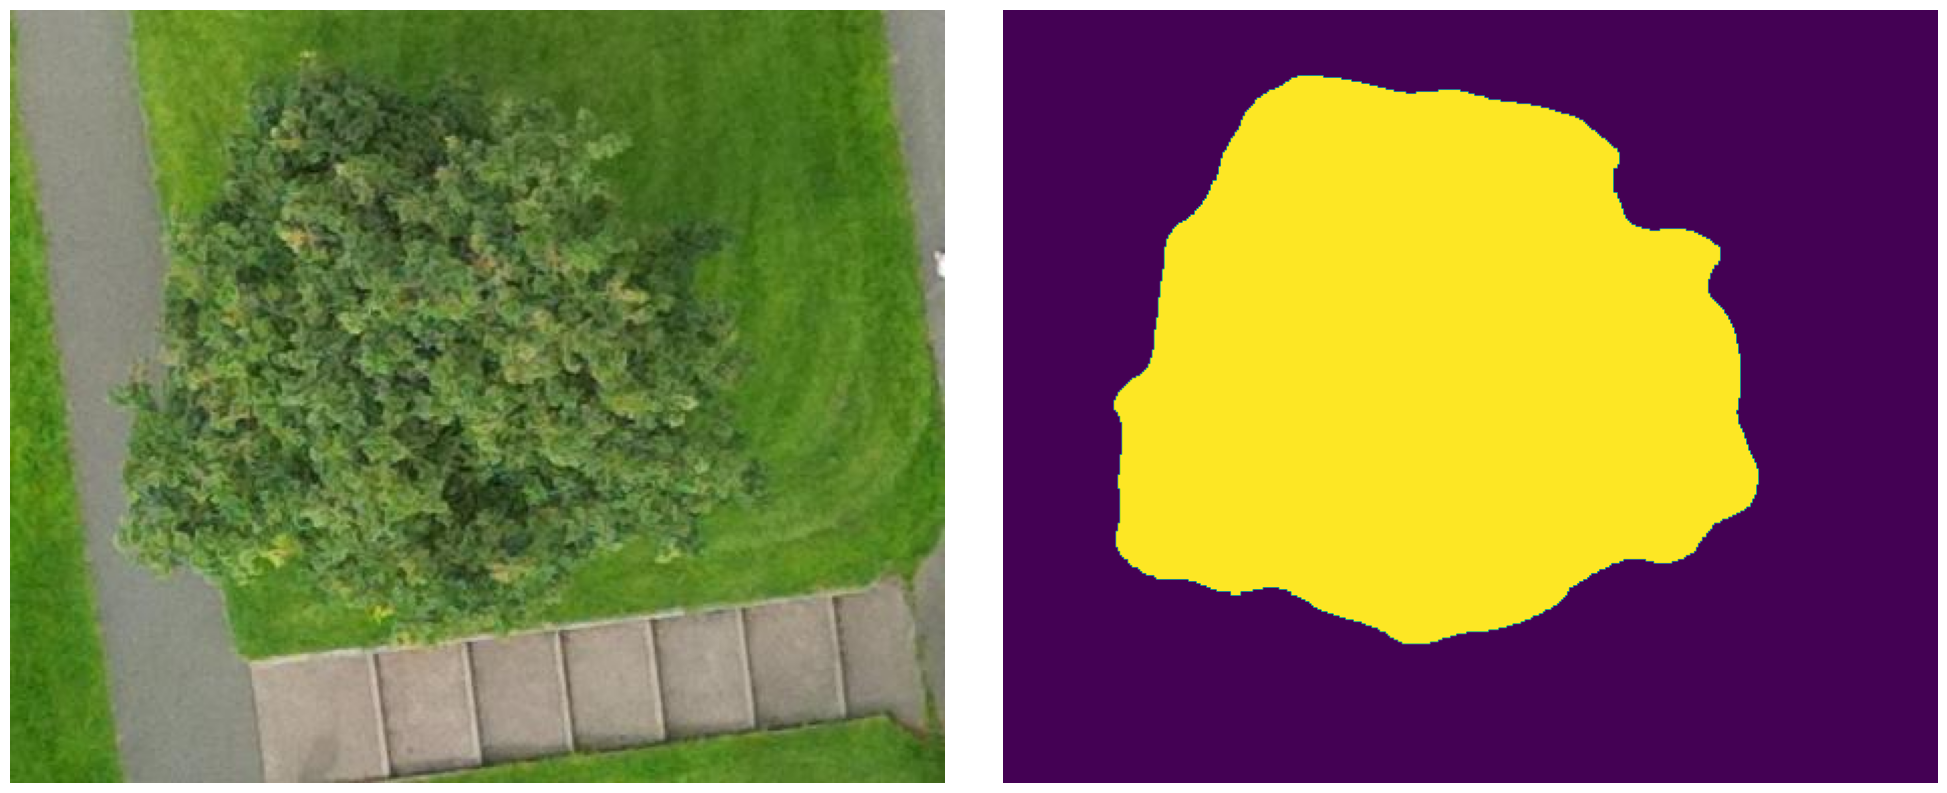

In [23]:
show_in_grid([image, ensemble_mask], num_rows=1, num_cols=2, show_plot=True)
plt.show()

## Ensemble

In [24]:
file_list = list(submissions[0].keys())

return_dict = {}

for file in tqdm.tqdm(file_list):
    masks = []
    weights = []
    for i, submission in enumerate(submissions):
        rle = submission[file]['counts']
        h = submission[file]['height']
        w = submission[file]['width']
        mask = rle_to_mask(rle, (w, h))
        masks.append(mask)
        weights.append(df.iloc[i]['weight'])
    image = Image.open(os.path.join(TEST_DATA_DIR, file))
    ensemble_mask = weighted_average_ensemble_masks(masks, weights, CONSENSUS_RATIO)
    if USE_POST_PROCESSING:
        ensemble_mask = post_process_mask(ensemble_mask, MIN_SIZE)
    assert ensemble_mask.shape[0] == image.size[1]
    assert ensemble_mask.shape[1] == image.size[0]

    rle = mask_to_rle(ensemble_mask)
    return_dict[file] = {
        'counts': rle,
        'height': ensemble_mask.shape[0],
        'width': ensemble_mask.shape[1]
    }
    
    # export to file
    
    # image-mask side by side
    image_mask = mask_to_rgb(ensemble_mask, {1: [55, 125, 34]})
    image_mask = np.concatenate([np.array(image), image_mask], axis=1)
    image_mask = Image.fromarray(image_mask)
    out_dir = 'ensemble_outputs'
    os.makedirs(out_dir, exist_ok=True)
    image_mask.save(os.path.join(out_dir, file))
    

  0%|          | 0/783 [00:00<?, ?it/s]

In [25]:

with open('results.json', 'w') as f:
    json.dump(return_dict, f)

In [26]:
!zip -r results.zip results.json

  adding: results.json (deflated 65%)
